# Plotting results



In [1]:
# Hello Max!
import numpy as np
import networkx as nx
from agent import Agent
from model import Model
from hybrid_networks import create_hybrid_network
from tqdm import tqdm
from hybrid_networks_clean import rewire_network, randomize_network_v2, create_hybrid_network


%load_ext autoreload
%autoreload 2                      

In [102]:
import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_j")
import colormaps as cmaps 

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [ ]:
def generate_markdown(data):
    markdown = []

    # Add general information
    markdown.append("## Model Summary Table\n")
    markdown.append("| | |")
    markdown.append("|-------------------------------|--------------|")
    markdown.append(f"| **Number of Samples:**                      | {np.round(data['n_samples'],3)}                                                       |")
    markdown.append(f"| **Number of Features:**                     | {np.round(data['m_features'],3)}                                                    |")
    markdown.append(f"| **Effective DoF:**                          | {np.round(data['edof'],3)}                                                    |")
    markdown.append(f"| **Log Likelihood:**                         | {np.round(data['loglikelihood'],3)}                                                |")
    markdown.append(f"| **AIC:**                                    | {np.round(data['AIC'],3)}                                                 |")
    markdown.append(f"| **AICc:**                                   | {np.round(data['AICc'],3)}                                                 |")
    markdown.append(f"| **GCV:**                                    | {np.round(data['GCV'],3)}                                                    |")
    markdown.append(f"| **Scale:**                                  | {np.round(data['scale'],3)}                                                    |")
    markdown.append(f"| **Pseudo R-Squared:**                       | {np.round(data['pseudo_r2']['explained_deviance'],3)}                                                    |")
    
    markdown.append("\n### Significance Codes\n")
    markdown.append("| Feature Function | SE | P > x | Sig. Code |")
    markdown.append("|------------------|--------|------|-------|-----------|")

    for i, (edof, se, p_value) in enumerate(zip(data['edof_per_coef'], data['se'], data['p_values'])):
        sig_code = ''
        if p_value < 0.001:
            sig_code = '***'
        elif p_value < 0.01:
            sig_code = '**'
        elif p_value < 0.05:
            sig_code = '*'
        elif p_value < 0.1:
            sig_code = '.'
        
        markdown.append(f"| **s({i})**         | {se:.6f}  | {edof:.6f}  | {p_value:.6f}  | {sig_code} |")

    markdown.append("\n*Significance codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1*")

    return "\n".join(markdown)

In [30]:
output_dir = 'talk_munich/images/'

In [31]:
import pandas as pd
from pygam import LogisticGAM,LinearGAM, s   
from sklearn.model_selection import train_test_split

In [32]:
data_df = pd.read_csv('bayesagent_perceptron_results_df.csv')

In [33]:
import dill

# Use dill to deserialize the graph from a file
with open('data_proc/perceptron_graph_pre_1979.pkl', 'rb') as f:
    G_perceptron = dill.load(f)


In [34]:
randomize_by = [0,.2,.4,.6,.8,1.]

In [35]:
import graph_tool.all as gt


for this_rand_value in randomize_by:
    G_randomized = randomize_network_v2(G_perceptron, p_rewiring=this_rand_value)
    # Convert NetworkX graph to graph_tool graph
    g = gt.Graph(directed=True)

    # Create a mapping from NetworkX nodes to graph_tool vertices
    node_map = {n: g.add_vertex() for n in G_randomized.nodes()}

    # Add edges to the graph_tool graph
    for u, v in G_randomized.edges():
        g.add_edge(node_map[u], node_map[v])
        
        
    pos = gt.sfdp_layout(g)
    dprms = dict(fmt="png",  output_size=(1200, 1200))
    gt.graph_draw( g, pos, output =output_dir + f"perceptron_graph_randomized_p={this_rand_value}.png")


In [36]:
import powerlaw


def plot_loglog(G, filename=None):
    # Calculate degree frequency
    degree_freq = nx.degree_histogram(G)
    degrees = range(len(degree_freq))
    print(degree_freq)
    # Filter out zero frequencies to avoid issues in loglog plots and fitting
    nonzero_degrees = [degree for degree, freq in enumerate(degree_freq) if freq > 0]
    nonzero_freqs = [freq for freq in degree_freq if freq > 0]
    
    # Fit the power law model to the nonzero frequencies
    fit = powerlaw.Fit(nonzero_freqs, discrete=True, xmin=min(nonzero_degrees))
    alpha, sigma = fit.alpha, fit.sigma
    print(f"Alpha: {alpha}, Sigma: {sigma}")
    #
    # Plot the original degree distribution
    plt.figure(figsize=(8, 8))
    plt.loglog(nonzero_degrees, [d / len(G)  for d in nonzero_freqs], 'o', c='#ab0b00', alpha=.9, label='Degree distribution')
    
    # Generate and plot the power law trend line over the observed range
    print(nonzero_degrees)
    #plt.loglog(nonzero_degrees, [fit.power_law.pdf(d)  for d in nonzero_degrees], 'k-', label=f'Power law fit (α={np.round(alpha,2)})')
    
    plt.xlabel('Degree')
    plt.ylabel('Frequency of Degree')
   #plt.legend(pos,loc='upper right')
    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.close()
    #plt.show()



for this_rand_value in randomize_by:
    G_randomized = randomize_network_v2(G_perceptron, p_rewiring=this_rand_value)
    
    plot_loglog(G_randomized, filename = output_dir + f"perceptron_graph_randomized_p={this_rand_value}_powerlaw_fit.png")

[0, 1825, 664, 343, 157, 109, 37, 39, 48, 26, 17, 16, 13, 15, 7, 6, 15, 7, 9, 6, 13, 13, 10, 3, 4, 8, 10, 3, 8, 4, 3, 6, 3, 3, 2, 1, 4, 1, 2, 3, 1, 3, 4, 0, 1, 3, 3, 1, 3, 0, 3, 2, 0, 0, 2, 0, 0, 4, 1, 1, 1, 0, 0, 0, 0, 1, 3, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [37]:

data_df['converged'] = data_df['convergence_step']< 10000
print('N. unconverged simulations: ', np.sum(~ data_df['converged']))
data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
data_df

N. unconverged simulations:  2


,n_agents,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,convergence_step,agent_type,converged,share_of_correct_agents_at_conv
0,3519,0.441173,0.016661,7427,randomize,4.346689,0.773231,6,bayes,True,0.773231
1,3519,0.817119,0.009739,1912,randomize,4.346121,0.897698,28,bayes,True,0.897698
2,3519,0.798491,0.022603,5749,randomize,4.346689,0.903666,7,bayes,True,0.903666
3,3519,0.384941,0.003522,5838,randomize,4.345553,0.705030,55,bayes,True,0.705030
4,3519,0.404991,0.024896,5526,randomize,4.346689,0.780619,6,bayes,True,0.780619
...,...,...,...,...,...,...,...,...,...,...,...
1995,3519,0.583912,0.021065,4549,randomize,4.346121,0.849957,7,bayes,True,0.849957
1996,3519,0.188740,0.007631,7496,randomize,4.346121,0.619494,14,bayes,True,0.619494
1997,3519,0.847185,0.002986,757,randomize,4.346121,0.874680,526,bayes,True,0.874680
1998,3519,0.145805,0.015593,352,randomize,4.346689,0.557829,50,bayes,True,0.557829


<Axes: xlabel='convergence_step', ylabel='Count'>

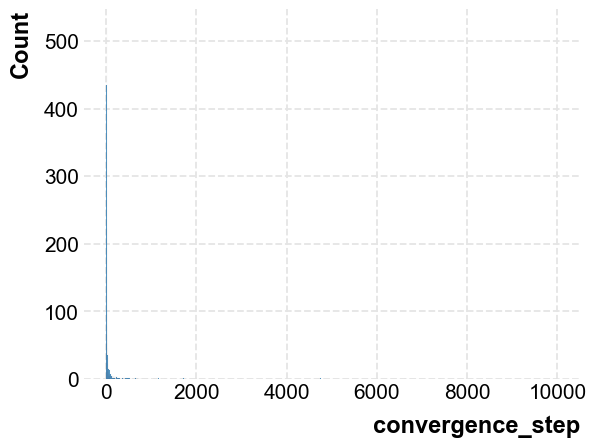

In [38]:
import seaborn as sns

sns.histplot(data_df['convergence_step'])

In [39]:
"true_consensus", "choice_consensus" and "convergence_step"

('true_consensus', 'convergence_step')

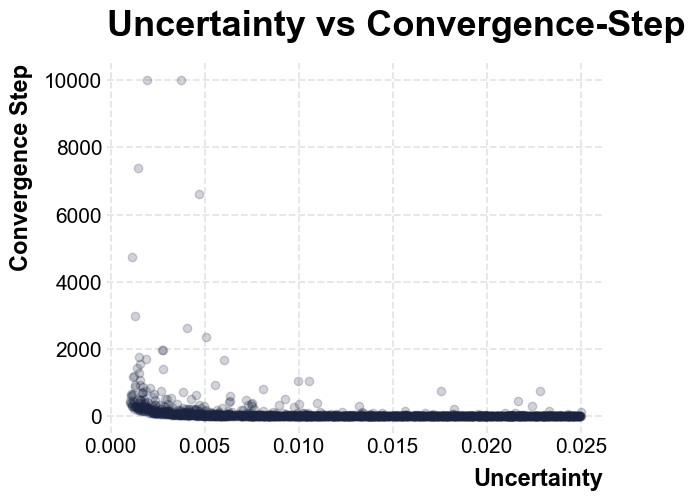

In [40]:
# Creating the scatter plot
plt.scatter(data_df['uncertainty'], data_df['convergence_step'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('Uncertainty')  # X-axis label
plt.ylabel('Convergence Step')  # Y-axis label
plt.title('Uncertainty vs Convergence-Step')  # Title of the plot

# Show the plot
plt.show()

## Predicting 'share_correct_at_convergence'


In [41]:

 
    # Preparing the data
X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = data_df['share_of_correct_agents_at_conv']

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/2045109881.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


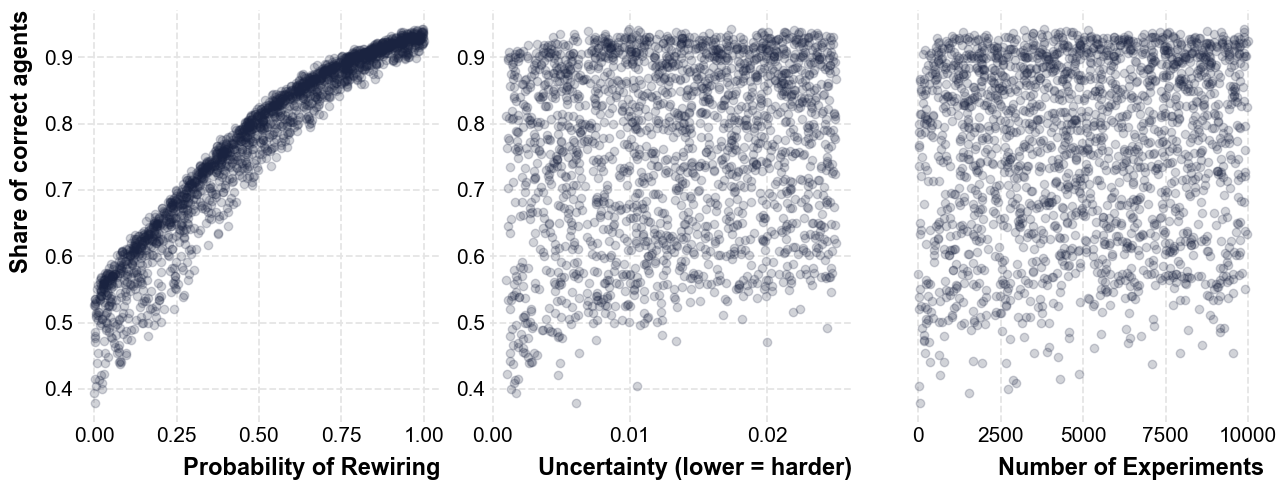

In [47]:
rename_dict = {
    'n_agents': 'Number of Agents',
    'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Uncertainty (lower = harder)',
    'n_experiments': 'Number of Experiments',
    'share_of_correct_agents_at_conv': 'Share of correct agents'
}

# Renaming columns in X for better readability
X.rename(columns=rename_dict, inplace=True)


# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))  # Adjust the size as needed
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, c='#1a2340', alpha=.2)
    axes[i].set_xlabel(rename_dict.get(col, col))  # Use renamed label
    if i == 0:
        axes[i].set_ylabel(rename_dict['share_of_correct_agents_at_conv'])
    #axes[i].set_title(f'{rename_dict.get(col, col)}')
    plt.gca().set_yticks([])
    plt.gca().set_yticklabels([])

plt.tight_layout()


plt.savefig(output_dir + f"perceptron_graph_randomized_pred_share_conv_data.png", dpi=300, transparent=True)

    
plt.show()

In [85]:


# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)

# print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
# print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.3633
Link Function:                     IdentityLink Log Likelihood:                               -118946.5835
Number of Samples:                          350 AIC:                                           237913.8935
                                                AICc:                                           237914.589
                                                GCV:                                                0.0015
                                                Scale:                                              0.0014
                                                Pseudo R-Squared:                                   0.9547
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3553637546.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


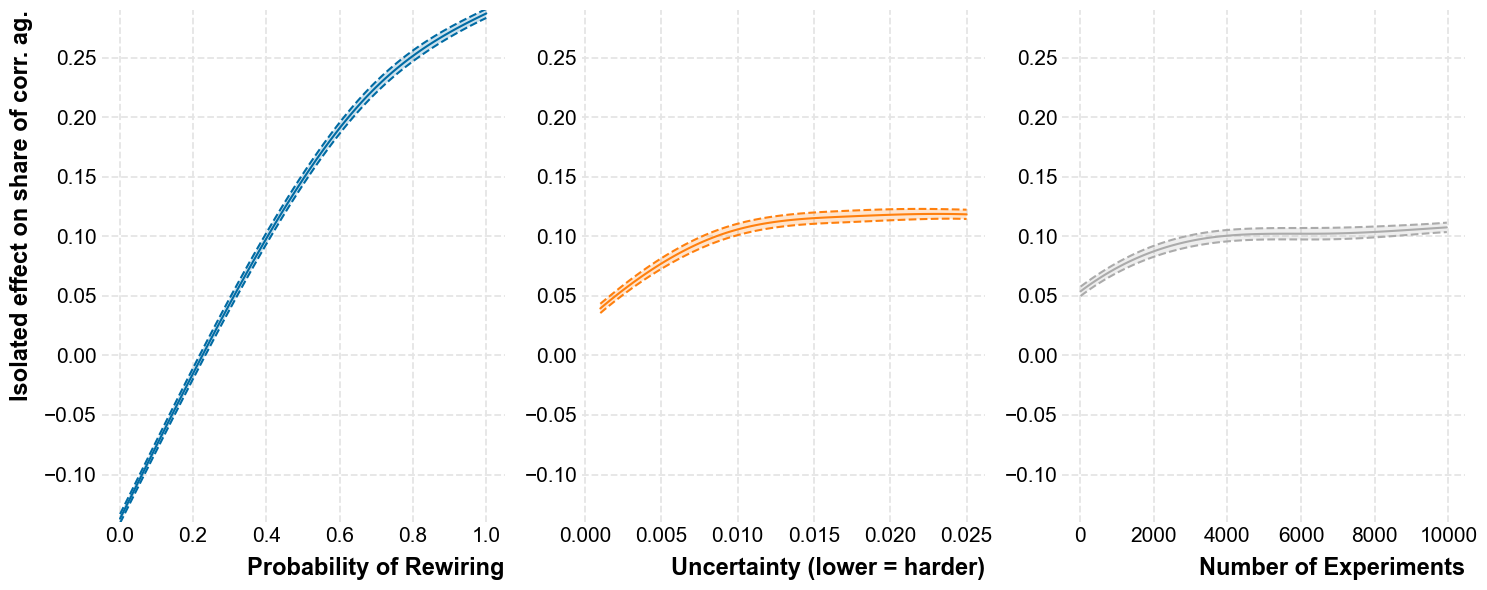

In [46]:

cmap= cmaps.colorblind_10



colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]



import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels = X.columns
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.99)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    #plt.title(labels[i])
    plt.xlabel(labels[i])  # Remove x-axis label
    #plt.ylabel('')  # Remove y-axis label
    if i == 0:
        
        axes[i].set_ylabel('Isolated effect on share of corr. ag.')


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  


## predicting convergence steps

In [91]:
 
    # Preparing the data
X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = np.log(data_df['convergence_step'])

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/834728223.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


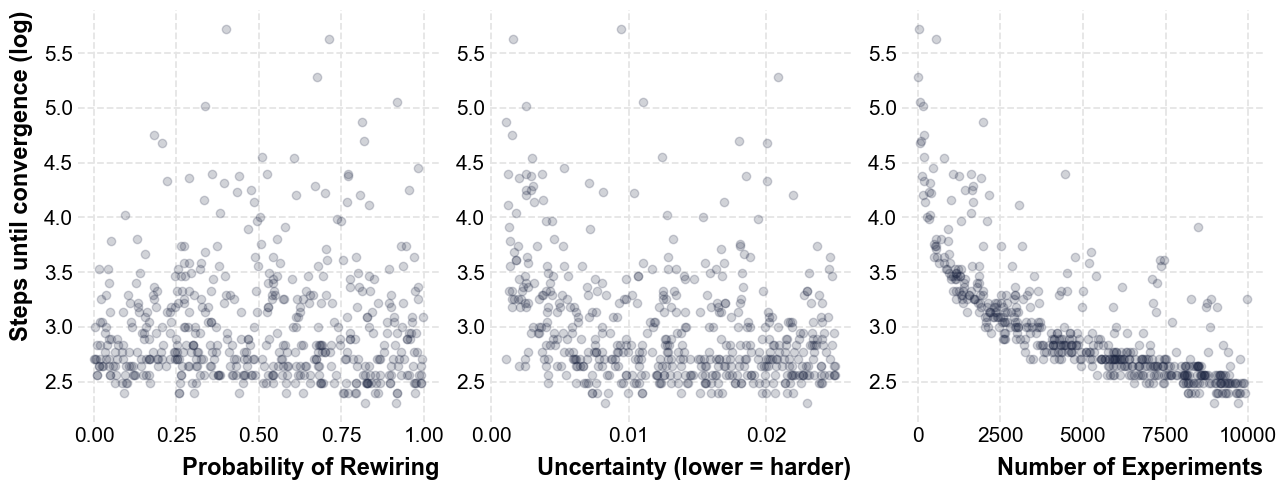

In [92]:
rename_dict = {
    'n_agents': 'Number of Agents',
    'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Uncertainty (lower = harder)',
    'n_experiments': 'Number of Experiments',
    'convergence_step': 'Steps until convergence (log)'
}

# Renaming columns in X for better readability
X.rename(columns=rename_dict, inplace=True)


# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))  # Adjust the size as needed
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, c='#1a2340', alpha=.2)
    axes[i].set_xlabel(rename_dict.get(col, col))  # Use renamed label
    if i == 0:
        axes[i].set_ylabel(rename_dict['convergence_step'])
    #axes[i].set_title(f'{rename_dict.get(col, col)}')
    #axes[i].set_yscale('log')  # Set y-scale to log for each axis

plt.tight_layout()
plt.show()

In [93]:


# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)

# print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
# print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.3633
Link Function:                     IdentityLink Log Likelihood:                                 -3091.3568
Number of Samples:                          350 AIC:                                             6203.4401
                                                AICc:                                            6204.1356
                                                GCV:                                                0.0463
                                                Scale:                                              0.0441
                                                Pseudo R-Squared:                                   0.8527
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3553637546.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


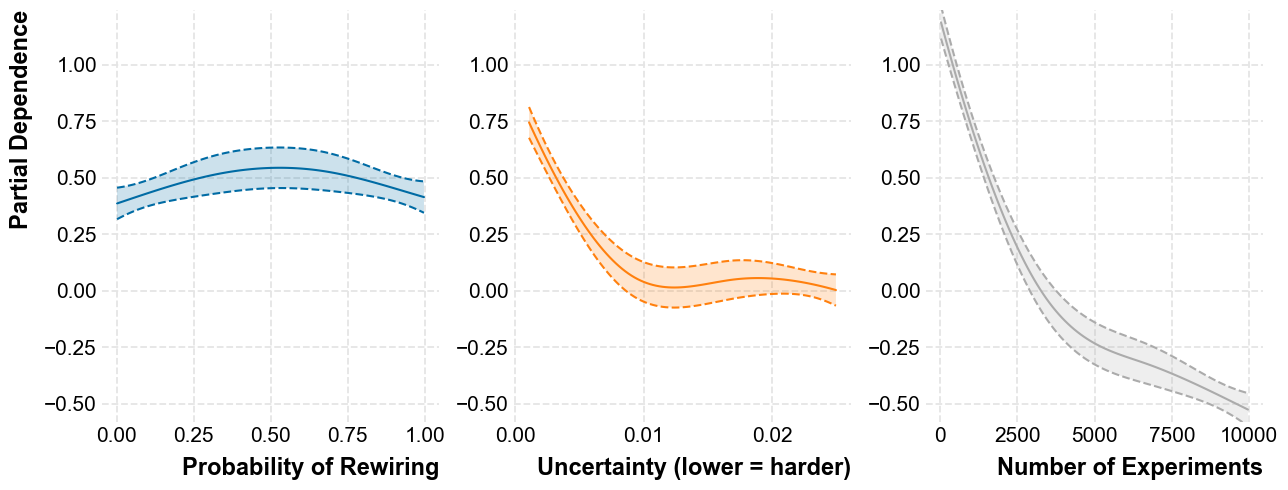

In [94]:

cmap= cmaps.colorblind_10



colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]



import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels = X.columns
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.99)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    #plt.title(labels[i])
    plt.xlabel(labels[i])  # Remove x-axis label
    #plt.ylabel('')  # Remove y-axis label
    if i == 0:
        
        axes[i].set_ylabel('Partial Dependence')


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  


# Bayes-agent-results


In [61]:
data_df = pd.read_csv('bayesagent_results_df.csv')
import dill

In [62]:

data_df['converged'] = data_df['convergence_step']< 10000
print('N. unconverged simulations: ', np.sum(~ data_df['converged']))
data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
data_df

N. unconverged simulations:  155


,n_agents,ba_degree,er_prob,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,network_type,true_consensus,convergence_step,agent_type,converged,share_of_correct_agents_at_conv
0,50,3,0.001581,0.314585,0.009161,88,randomize,5.480000,ba,1.000000,123,bayes,True,1.000000
1,115,6,0.104298,0.934059,0.002747,94,randomize,10.973913,ba,1.000000,574,bayes,True,1.000000
2,76,5,0.223489,0.998311,0.002316,35,randomize,9.052632,ba,1.000000,1873,bayes,True,1.000000
3,58,3,0.203830,0.041382,0.009668,70,randomize,5.689655,ba,1.000000,129,bayes,True,1.000000
4,132,2,0.144579,0.650044,0.003101,31,randomize,3.909091,ba,0.977273,3863,bayes,True,0.977273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,65,8,0.166648,0.831336,0.001522,61,randomize,8.000000,ws,1.000000,2666,bayes,True,1.000000
2996,22,8,0.236724,0.631580,0.004028,30,randomize,8.000000,ws,1.000000,400,bayes,True,1.000000
2997,145,4,0.160007,0.177034,0.009306,61,randomize,4.000000,ws,1.000000,167,bayes,True,1.000000
2998,104,3,0.182446,0.119717,0.001778,16,randomize,2.000000,ws,0.903846,10000,bayes,False,0.903846


<Axes: xlabel='convergence_step', ylabel='Count'>

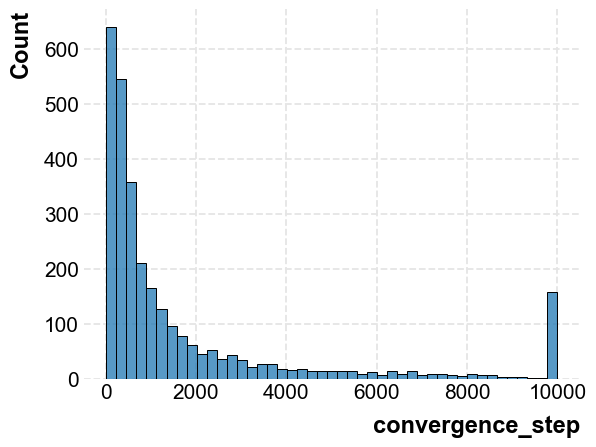

In [63]:
import seaborn as sns

sns.histplot(data_df['convergence_step'])
#"true_consensus", "choice_consensus" and "convergence_step"


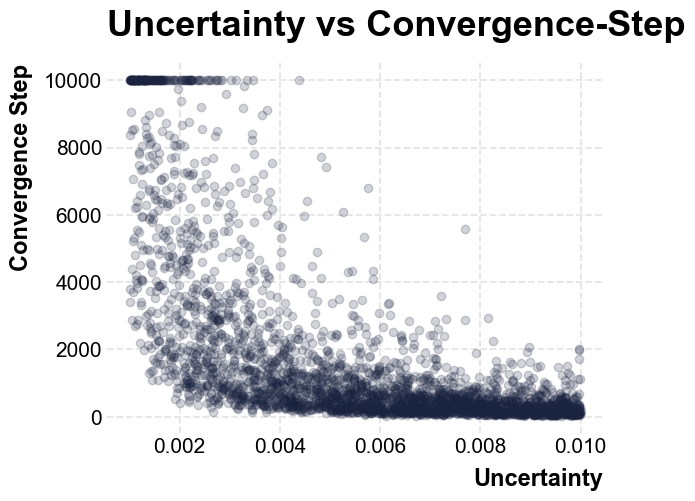

In [64]:
# Creating the scatter plot
plt.scatter(data_df['uncertainty'], data_df['convergence_step'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('Uncertainty')  # X-axis label
plt.ylabel('Convergence Step')  # Y-axis label
plt.title('Uncertainty vs Convergence-Step')  # Title of the plot

# Show the plot
plt.show()

In [65]:
# 

### Barabasi-Albert-graph

In [235]:



    # Preparing the data
X = data_df[['p_rewiring',	'uncertainty',	'n_experiments', 'mean_degree']][data_df['network_type']=='ba']
y = data_df['share_of_correct_agents_at_conv'][data_df['network_type']=='ba']

In [236]:

rename_dict = {
    'n_agents': 'Number of Agents',
    'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Uncertainty Level',
    'n_experiments': 'Number of Experiments',
    'share_of_correct_agents_at_conv': 'Share of correct agents',
    'mean_degree': 'Mean Degree'
}

# Renaming columns in X for better readability
X.rename(columns=rename_dict, inplace=True)

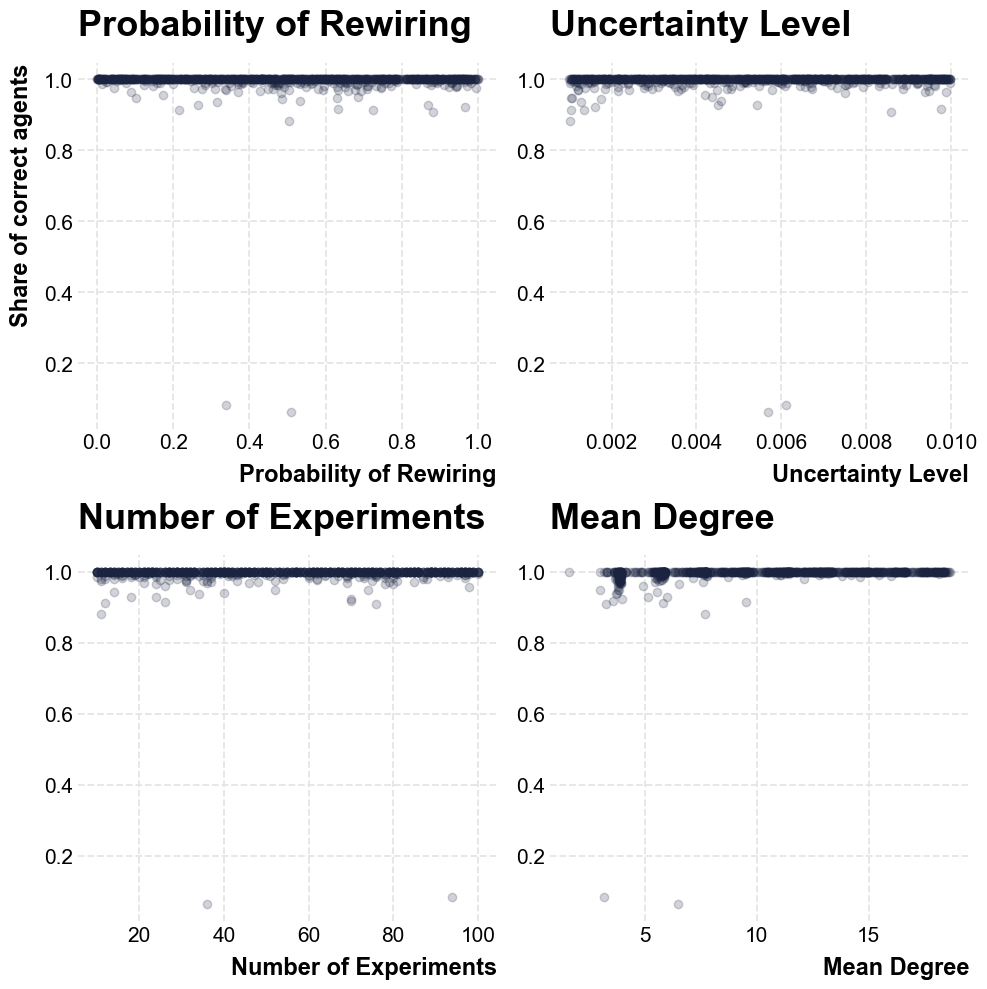

In [237]:

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))  # Adjust the size as needed
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, c='#1a2340', alpha=.2)
    axes[i].set_xlabel(rename_dict.get(col, col))  # Use renamed label
    if i == 0:
        axes[i].set_ylabel(rename_dict['share_of_correct_agents_at_conv'])
    axes[i].set_title(f'{rename_dict.get(col, col)}')

plt.tight_layout()
plt.show()


In [223]:
gam.__dict__

{'scale': None,
 'max_iter': 100,
 'tol': 0.0001,
 'distribution': NormalDist(),
 'link': IdentityLink(),
 'callbacks': [Deviance(), Diffs()],
 'verbose': False,
 'terms': s(0) + s(1) + s(2) + intercept,
 'fit_intercept': True,
 '_constraint_lam': 1000000000.0,
 '_constraint_l2': 0.001,
 '_constraint_l2_max': 0.1,
 '_term_location': 'terms',
 '_name': None,
 '_line_width': 70,
 '_line_offset': 3,
 '_exclude': ['distribution', 'link'],
 '_include': [],
 'logs_': defaultdict(list,
             {'deviance': [1925.784076306614, 17.485577013928935],
              'diffs': [0.9999999389640168, 4.3900432592352055e-17]}),
 'statistics_': {'n_samples': 2100,
  'm_features': 3,
  'edof_per_coef': array([9.32839394e-01, 7.46711538e-01, 7.76090854e-01, 8.78840972e-01,
         8.96424918e-01, 2.77763937e-01, 9.17840644e-01, 7.30178786e-01,
         7.61918976e-01, 8.32730825e-01, 2.76252445e-01, 1.22137803e-03,
         9.14375374e-01, 7.36561104e-01, 7.57913731e-01, 8.28641633e-01,
         2.789

In [225]:
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) + s(3,n_splines=6) ).fit(X_train, y_train)

# print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
# print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     14.9103
Link Function:                     IdentityLink Log Likelihood:                               -140419.6615
Number of Samples:                         2100 AIC:                                           280871.1437
                                                AICc:                                          280871.4021
                                                GCV:                                                0.0071
                                                Scale:                                               0.007
                                                Pseudo R-Squared:                                   0.1857
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_46130/3638153939.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


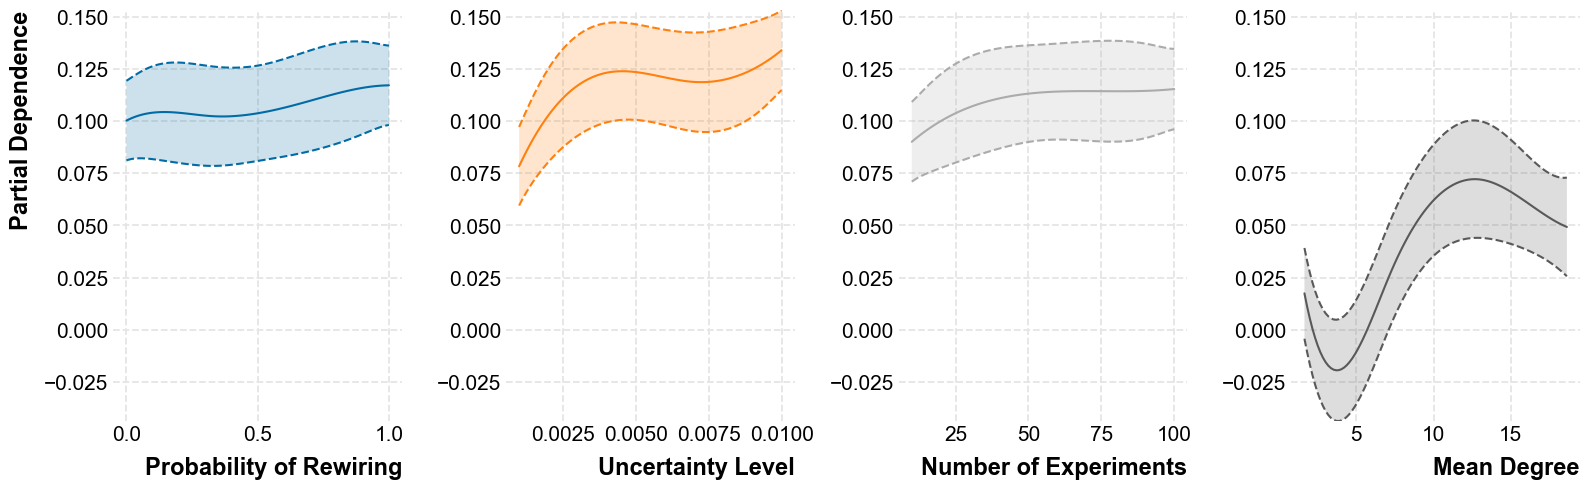

In [230]:



cmap= cmaps.colorblind_10



colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2), cmap(1/cmap.N*3)]



import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels = X.columns
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.99)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.99)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    #plt.title(labels[i])
    plt.xlabel(labels[i])  # Remove x-axis label
    #plt.ylabel('')  # Remove y-axis label
    if i == 0:
        
        axes[i].set_ylabel('Partial Dependence')


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  



### Watts-Strogatz

In [66]:



    # Preparing the data
X = data_df[['mean_degree','ba_degree', 'p_rewiring', 'uncertainty', 'n_experiments', ]][data_df['network_type']=='ws']
y = data_df['share_of_correct_agents_at_conv'][data_df['network_type']=='ws']

In [67]:

rename_dict = {
    'n_agents': 'Number of Agents',
    'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Uncertainty Level',
    'n_experiments': 'Number of Experiments',
    'share_of_correct_agents_at_conv': 'Share of correct agents',
    'mean_degree': 'Mean Degree',
    'ba_degree' : 'WS-neighbors'
}

# Renaming columns in X for better readability
X.rename(columns=rename_dict, inplace=True)

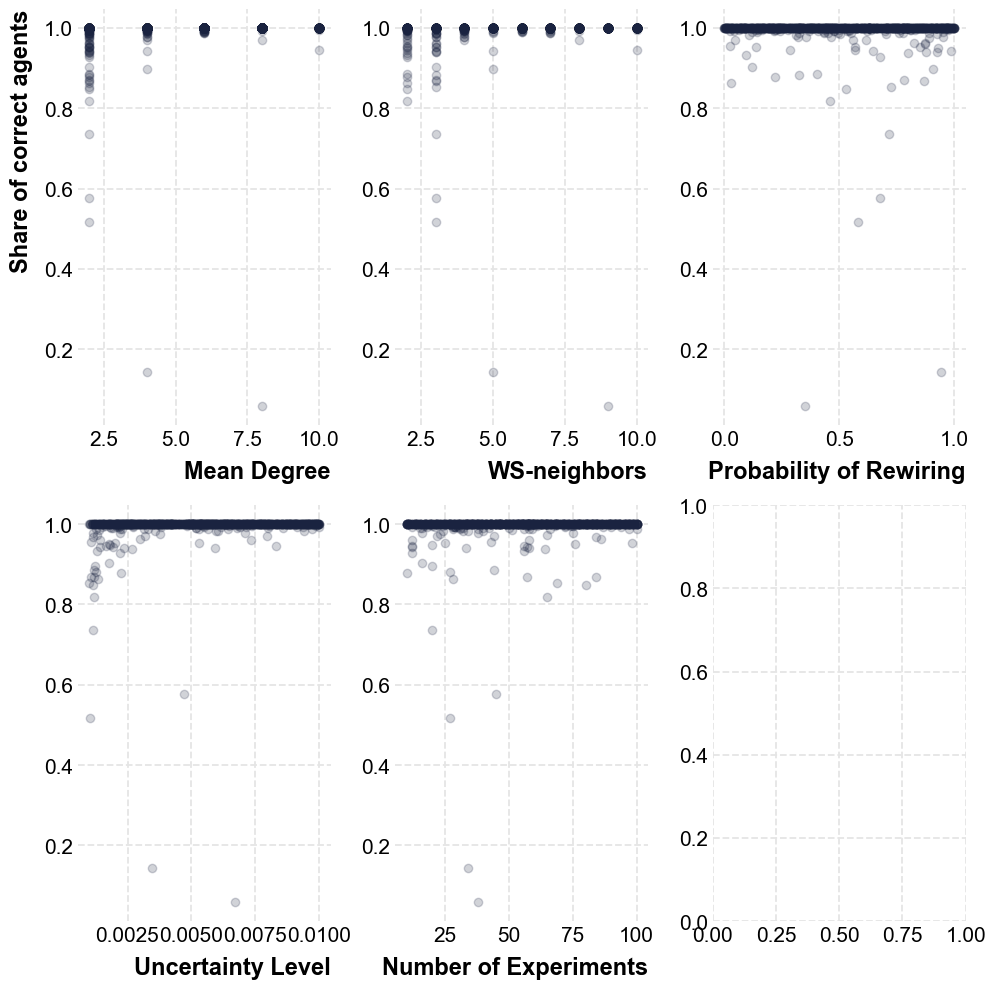

In [68]:

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))  # Adjust the size as needed
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, c='#1a2340', alpha=.2)
    axes[i].set_xlabel(rename_dict.get(col, col))  # Use renamed label
    if i == 0:
        axes[i].set_ylabel(rename_dict['share_of_correct_agents_at_conv'])
    #axes[i].set_title(f'{rename_dict.get(col, col)}')

plt.tight_layout()
plt.show()


In [79]:
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) + s(3,n_splines=6)+ s(4,n_splines=6),
                max_iter=10000,tol=0.00001,verbose=True).fit(X_train, y_train)
#gam.gridsearch(X_train, y_train)
# print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
# print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.7391
Link Function:                     IdentityLink Log Likelihood:                               -667491.2935
Number of Samples:                          700 AIC:                                          1335016.0653
                                                AICc:                                         1335016.9357
                                                GCV:                                                0.0005
                                                Scale:                                              0.0005
                                                Pseudo R-Squared:                                   0.1404
Feature Function                  Lam

/Users/Noich001/miniforge3/envs/network_epist_playground/lib/python3.12/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/4168073109.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


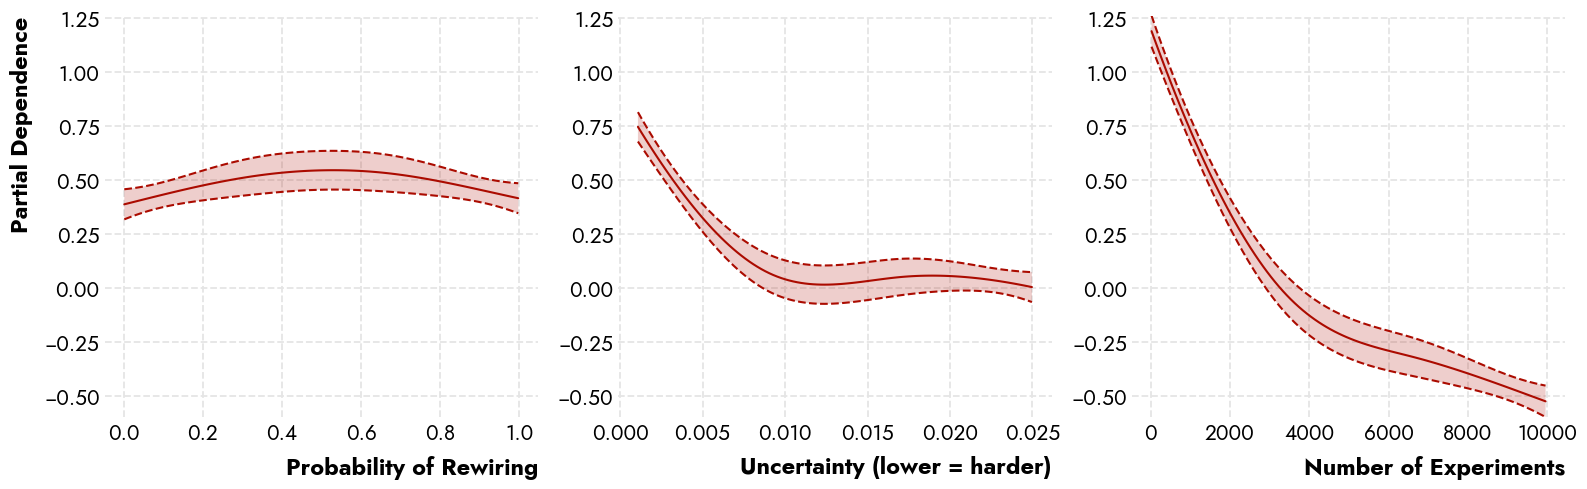

In [119]:
def plot_partial_dependence(gam, hex_colors, feature_names, filename=None):
    """
    Plots partial dependence plots for all terms in a GAM model.
    
    Parameters:
    gam : object
        The generalized additive model object containing the terms and methods.
    hex_colors : list of str
        List of hex color codes to use for the plots.
    feature_names : list of str
        List of feature names corresponding to the terms in the model.
    """
    
    plot_count = sum(not term.isintercept for term in gam.terms)
    fig, axes = plt.subplots(nrows=1, ncols=plot_count, figsize=(16, 5))  # Adjust size as needed

    y_limits = []
    current_plot = 0

    # First pass: compute the y-axis limits for all plots
    for I, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        XX = gam.generate_X_grid(term=I)
        pdep, confi = gam.partial_dependence(term=I, X=XX, width=0.99)
        y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

    global_y_min = min(limit[0] for limit in y_limits)
    global_y_max = max(limit[1] for limit in y_limits)

    # Second pass: plot with standardized y limits
    for I, term in enumerate(gam.terms):
        if term.isintercept:
            continue

        XX = gam.generate_X_grid(term=I)
        pdep, confi = gam.partial_dependence(term=I, X=XX, width=0.99)

        ax = axes[current_plot]
        ax.plot(XX[:, term.feature], pdep, color=hex_colors[current_plot % len(hex_colors)])
        ax.plot(XX[:, term.feature], confi, color=hex_colors[current_plot % len(hex_colors)], ls='--')
        ax.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=hex_colors[current_plot % len(hex_colors)], alpha=0.2, interpolate=True)
        ax.set_ylim(global_y_min, global_y_max)
        ax.set_xlabel(feature_names[I])
        if current_plot == 0:
            ax.set_ylabel('Partial Dependence')

        current_plot += 1

    plt.tight_layout()
    
    
    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.close()
    #plt.show()

plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"={this_rand_value}_powerlaw_fit.png")

# Beta-Agents: Perceptron

In [95]:
data_df = pd.read_csv('betaagent_perceptron_results_df.csv')
import dill

data_df['converged'] = data_df['convergence_step']< 10000
print('N. unconverged simulations: ', np.sum(~ data_df['converged']))
data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
data_df

N. unconverged simulations:  0


,n_agents,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,convergence_step,agent_type,converged,share_of_correct_agents_at_conv
0,3519,0.167128,0.016293,7823,randomize,4.346121,0.641091,13,beta,True,0.641091
1,3519,0.336735,0.001628,5232,randomize,4.346689,0.417164,40,beta,True,0.417164
2,3519,0.792060,0.020601,8277,randomize,4.346689,0.896562,11,beta,True,0.896562
3,3519,0.617836,0.024003,2308,randomize,4.344984,0.852231,22,beta,True,0.852231
4,3519,0.312612,0.008055,6000,randomize,4.346121,0.679170,16,beta,True,0.679170
...,...,...,...,...,...,...,...,...,...,...,...
495,3519,0.674205,0.013683,5655,randomize,4.346121,0.869849,15,beta,True,0.869849
496,3519,0.154921,0.017435,2927,randomize,4.346689,0.622052,22,beta,True,0.622052
497,3519,0.827781,0.007085,2415,randomize,4.346689,0.862177,22,beta,True,0.862177
498,3519,0.608561,0.007434,4547,randomize,4.346121,0.805058,16,beta,True,0.805058


In [96]:

 
    # Preparing the data
X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = data_df['share_of_correct_agents_at_conv']


/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/1446775079.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


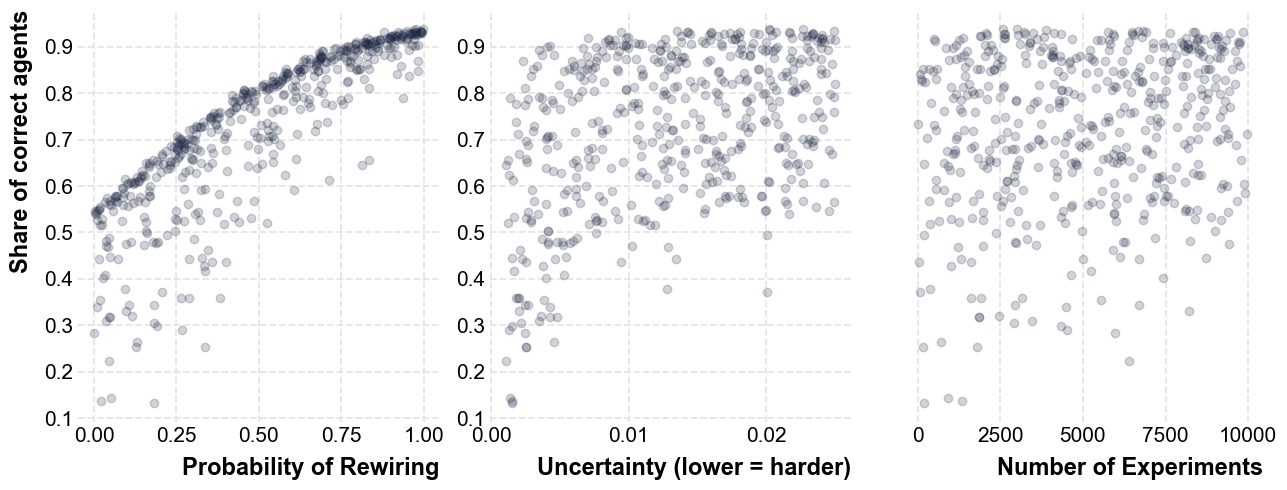

In [97]:



rename_dict = {
    'n_agents': 'Number of Agents',
    'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Uncertainty (lower = harder)',
    'n_experiments': 'Number of Experiments',
    'share_of_correct_agents_at_conv': 'Share of correct agents'
}

# Renaming columns in X for better readability
X.rename(columns=rename_dict, inplace=True)


# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))  # Adjust the size as needed
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, c='#1a2340', alpha=.2)
    axes[i].set_xlabel(rename_dict.get(col, col))  # Use renamed label
    if i == 0:
        axes[i].set_ylabel(rename_dict['share_of_correct_agents_at_conv'])
    #axes[i].set_title(f'{rename_dict.get(col, col)}')
    plt.gca().set_yticks([])
    plt.gca().set_yticklabels([])

plt.tight_layout()


plt.savefig(output_dir + f"perceptron_graph_randomized_pred_share_conv_data.png", dpi=300, transparent=True)

    
plt.show()

## predicting convergence steps

In [98]:

 
    # Preparing the data
X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = np.log(data_df['convergence_step'])
rename_dict = {
    'n_agents': 'Number of Agents',
    'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Uncertainty (lower = harder)',
    'n_experiments': 'Number of Experiments',
    'convergence_step': 'Steps until convergence (log)'
}

# Renaming columns in X for better readability
X.rename(columns=rename_dict, inplace=True)


/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/2917641511.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


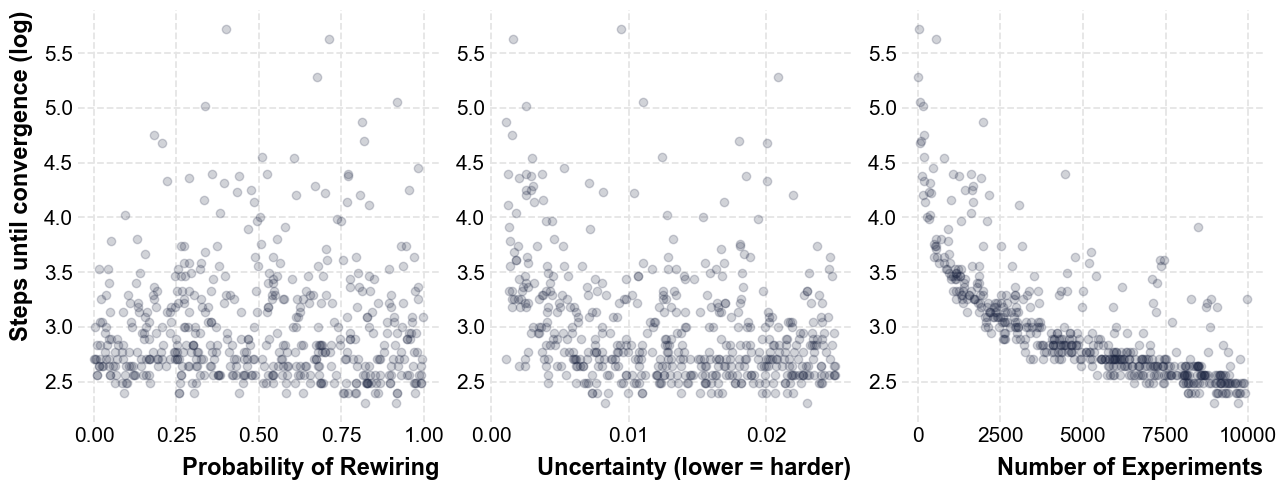

In [99]:


# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))  # Adjust the size as needed
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, c='#1a2340', alpha=.2)
    axes[i].set_xlabel(rename_dict.get(col, col))  # Use renamed label
    if i == 0:
        axes[i].set_ylabel(rename_dict['convergence_step'])
    #axes[i].set_title(f'{rename_dict.get(col, col)}')
    #axes[i].set_yscale('log')  # Set y-scale to log for each axis

plt.tight_layout()
plt.show()

In [111]:
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ,
                max_iter=10000,tol=0.00001,verbose=True).fit(X_train, y_train)
#gam.gridsearch(X_train, y_train)
# print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
# print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.3633
Link Function:                     IdentityLink Log Likelihood:                                 -3091.3568
Number of Samples:                          350 AIC:                                             6203.4401
                                                AICc:                                            6204.1356
                                                GCV:                                                0.0463
                                                Scale:                                              0.0441
                                                Pseudo R-Squared:                                   0.8527
Feature Function                  Lam

/Users/Noich001/miniforge3/envs/network_epist_playground/lib/python3.12/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/256282558.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


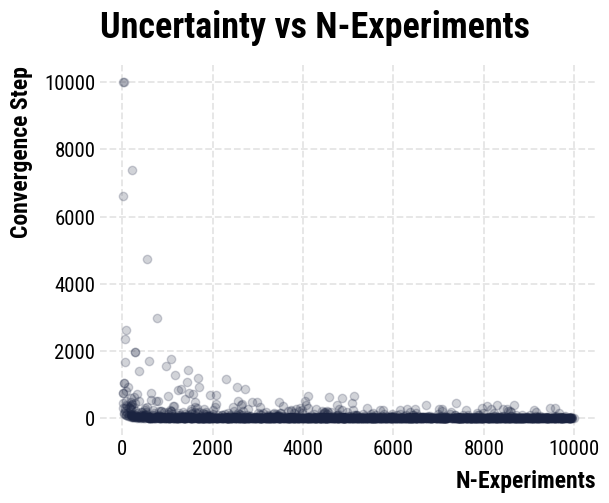

In [17]:
# Creating the scatter plot
plt.scatter(data_df['n_experiments'], data_df['convergence_step'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('N-Experiments')  # X-axis label
plt.ylabel('Convergence Step')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

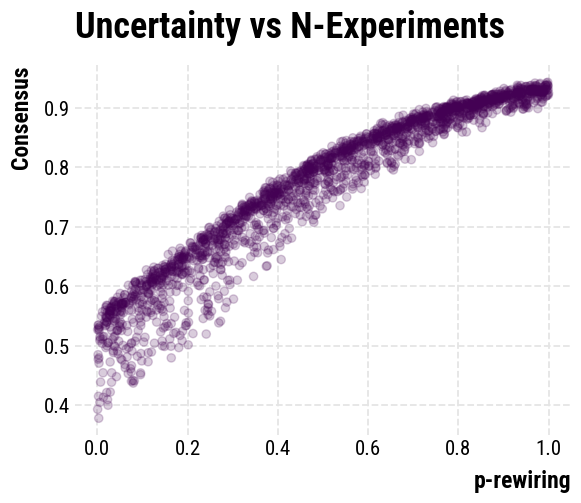

In [20]:
# Creating the scatter plot
plt.scatter(data_df['p_rewiring'], data_df['share_correct_at_convergence'], c=pd.factorize(data_df['rewiring_type'])[0],alpha=.2)

# Adding labels and title
plt.xlabel('p-rewiring')  # X-axis label
plt.ylabel('Consensus')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

In [ ]:
# Creating the scatter plot
plt.scatter(data_df['p_rewiring'], data_df['true_consensus'], c=pd.factorize(data_df['rewiring_type'])[0],alpha=.2)

# Adding labels and title
plt.xlabel('p-rewiring')  # X-axis label
plt.ylabel('Consensus')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

# Beta-Agent

In [44]:
data_df = pd.read_csv('betaagent_results_df.csv')

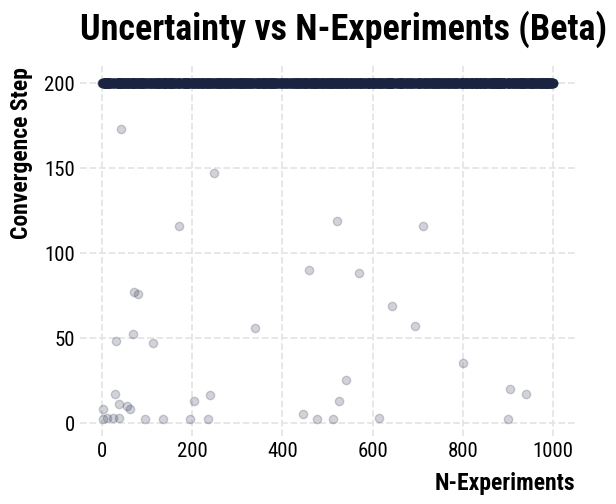

In [47]:
# Creating the scatter plot
plt.scatter(data_df['n_experiments'], data_df['convergence_step'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('N-Experiments')  # X-axis label
plt.ylabel('Convergence Step')  # Y-axis label
plt.title('Uncertainty vs N-Experiments (Beta)')  # Title of the plot

# Show the plot
plt.show()

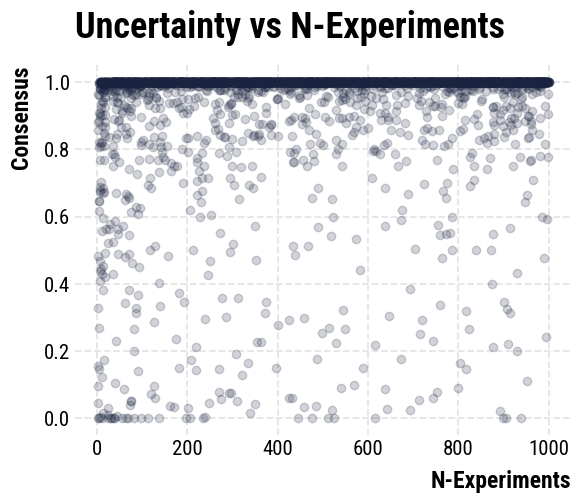

In [46]:
# Creating the scatter plot
plt.scatter(data_df['n_experiments'], data_df['true_consensus'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('N-Experiments')  # X-axis label
plt.ylabel('Consensus')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

In [41]:
!pip install pymc

  Using cached pymc-5.15.1-py3-none-any.whl.metadata (10 kB)
  Using cached arviz-0.18.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached cachetools-5.3.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached pytensor-2.22.1-cp312-cp312-macosx_11_0_arm64.whl
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
  Using cached dm_tree-0.1.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (1.9 kB)
  Using cached h5netcdf-1.3.0-py3-none-any.whl.metadata (13 kB)
  Using cached xarray_einstats-0.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached etuples-0.3.9-py3-none-any.whl
  Using cached logical_unification-0.4.6-py3-none-any.whl
  Using cached miniKanren-1.0.3-py3-none-any.whl
  Using cached cons-0.4.6-py3-none-any.whl
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached h5py-3.11.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached pymc-5.15.1-py3-none-any.whl (484 kB)
Using c

In [ ]:
# check powerlaw.

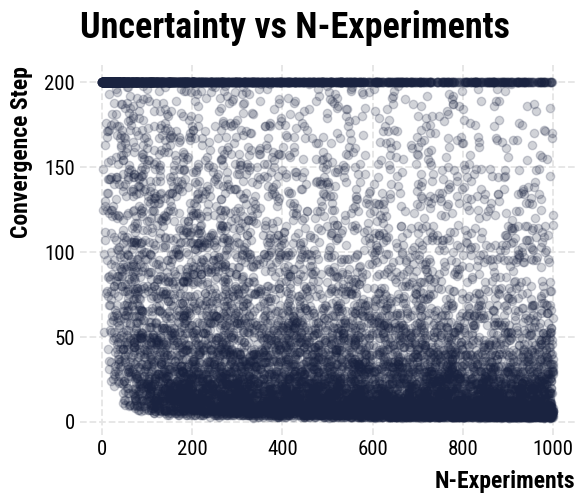

In [38]:
data_df = pd.read_csv('bayesagent_results_df.csv')
# Creating the scatter plot
plt.scatter(data_df['n_experiments'], data_df['convergence_step'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('N-Experiments')  # X-axis label
plt.ylabel('Convergence Step')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

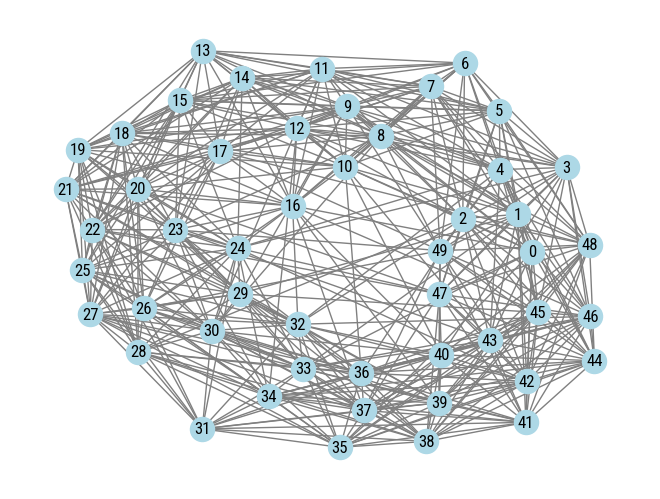

In [365]:
import networkx as nx
import matplotlib.pyplot as plt



# n is the number of nodes
# k is each node is connected to k nearest neighbors in ring topology
# p is the rewiring probability (set to 0 for a regular ring lattice)

n = 50  # number of nodes
k = 2  # each node is connected to 2 nearest neighbors on either side

G = nx.watts_strogatz_graph(n, k, 0.1)

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [9]:


# Splitting the DataFrame by network type
network_types = results_df['network_type'].unique()

my_gams = {}

for network_type in network_types:
    # Subset the DataFrame by network type
    subset = results_df[results_df['network_type'] == network_type]
    
    # Preparing the data
    X = subset[['n_agents']]
    y = subset['true_consensus'].astype(int)  # Convert boolean to integer
    
    # Splitting the data into training and testing sets for model validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Fitting the Logistic GAM model
    gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
    
    # Storing the model
    my_gams[network_type] = gam
    
    # Optionally, you can print out model accuracy or other statistics here
    print(f"Model for {network_type}:")
    print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
    print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
    print("-" * 30)


ModuleNotFoundError: No module named 'pygam'

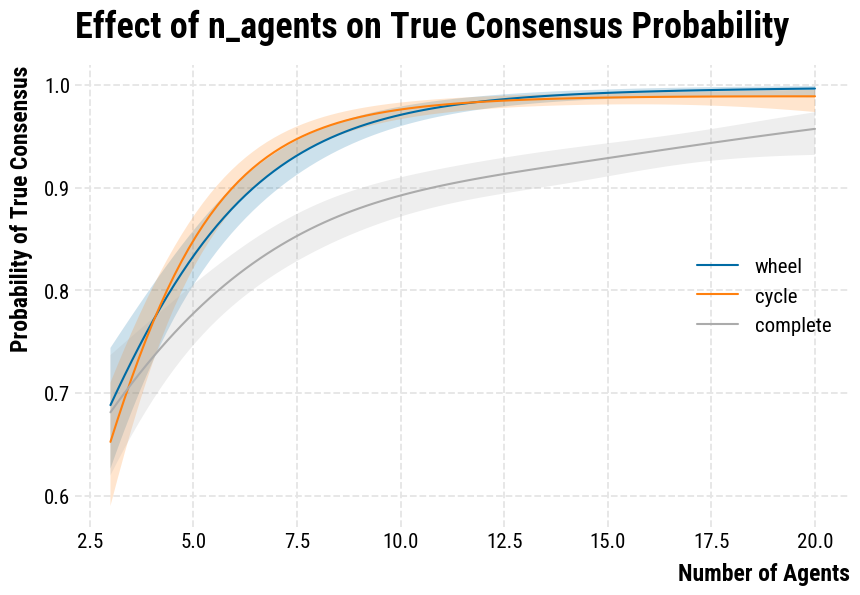

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the size of the figure
plt.figure(figsize=(10, 6))


cmap= cmaps.colorblind_10

X_range = np.linspace(X['n_agents'].min(), X['n_agents'].max(), 100)


colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]

for i, (network_type, gam) in enumerate(my_gams.items()):
    conf = gam.confidence_intervals(X_range.reshape(-1, 1), width=0.95, quantiles=None)
    plt.fill_between(X_range, conf[:, 0], conf[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)


for i, (network_type, gam) in enumerate(my_gams.items()):
    # Generating a range of values for n_agents to predict and plot
    
    
    # Predicting with the model
    #y_pred, conf = pdep, confi = model.partial_dependence(term=0, width=.95)
    y_pred = gam.predict_proba(X_range.reshape(-1, 1))

    
    # Plotting predicted probabilities
    plt.plot(X_range, y_pred,c=colors[i], label=f'{network_type}')
    
    # Plotting observed data

    # observed_data = results_df[results_df['network_type'] == network_type]
    # plt.scatter(observed_data['n_agents'] + np.random.rand(len(observed_data)), observed_data['true_consensus'], 
    #             alpha=0.01, c='grey',marker=2)


# Adding title, labels, and legend
plt.title('Effect of n_agents on True Consensus Probability')
plt.xlabel('Number of Agents')
plt.ylabel('Probability of True Consensus')
plt.legend()
plt.show()


9

# Tunable networks

In [ ]:
import random
import networkx as nx



def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 15)
        degree = random.randint(1, n_agents-1)
        p_preferential_attachment = random.uniform(0, 1)
        network = create_hybrid_network(n_agents, degree=degree, p_preferential_attachment=p_preferential_attachment)
        uncertainty = 0.001
        n_experiments = 1000 #random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "degree": degree,
            "p_preferential_attachment": p_preferential_attachment,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(50)


In [ ]:
parameter_dictionaries = generate_parameters(10000)  # Generate parameter dictionaries
results_df = batch_run_simulations(parameter_dictionaries, number_of_steps=100000, show_bar=False)
print(results_df)


Running simulations: 100%|██████████| 10000/10000 [01:15<00:00, 132.10it/s]

      n_agents  degree  p_preferential_attachment  uncertainty  n_experiments  \
0            4       2                   0.492210        0.001           1000   
1           12       7                   0.640592        0.001           1000   
2           13       3                   0.805594        0.001           1000   
3            6       5                   0.253219        0.001           1000   
4           11       5                   0.685990        0.001           1000   
...        ...     ...                        ...          ...            ...   
9995         6       5                   0.865813        0.001           1000   
9996        12       7                   0.784926        0.001           1000   
9997         6       2                   0.177675        0.001           1000   
9998         4       2                   0.691931        0.001           1000   
9999         9       1                   0.986273        0.001           1000   

      true_consensus  true_

In [ ]:
 
    # Preparing the data
X = results_df[['n_agents', 'degree', 'p_preferential_attachment']]
y = results_df['true_consensus'].astype(int)  # Convert boolean to integer

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LogisticGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ).fit(X_train, y_train)

print(f"Model for {network_type}:")
print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())


Model for complete:
Accuracy on training data: 0.7221428571428572
Accuracy on test data: 0.71
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     10.9616
Link Function:                        LogitLink Log Likelihood:                                 -3795.0395
Number of Samples:                         7000 AIC:                                             7612.0021
                                                AICc:                                            7612.0464
                                                UBRE:                                               3.0887
                                                Scale:                                                 1.0
                                                Ps

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_84390/3925743412.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


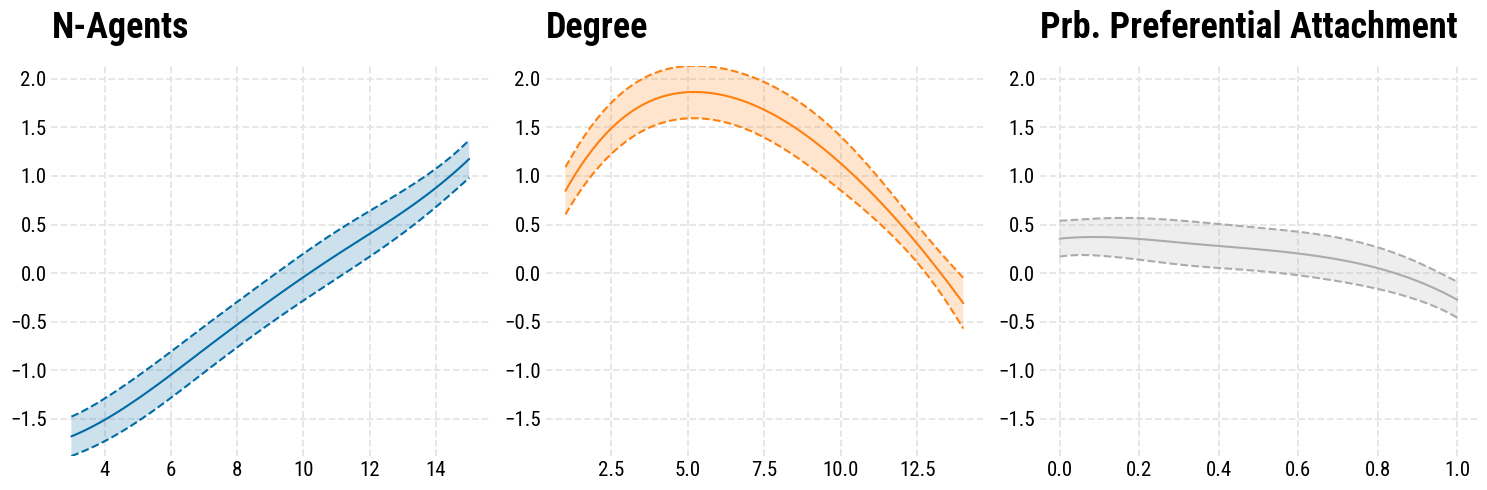

In [ ]:
import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
plt.figure(figsize=(15, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels =['N-Agents', 'Degree', 'Prb. Preferential Attachment']
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    plt.title(labels[i])
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel('')  # Remove y-axis label


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


# Randomized networks

In [94]:
import random
import networkx as nx
from hybrid_networks import randomized_barabasi_albert_graph

def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 100)
        n_edges_to_add = random.randint(1, np.max([int(n_agents/10),1])) #rethink
        randomization_probability = random.uniform(0, 1)
        network = randomized_barabasi_albert_graph(n_agents, 
                                                    n_edges_to_add=n_edges_to_add, 
                                                    randomization_probability=randomization_probability)
        uncertainty = 0.001
        n_experiments = 1000 #random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "n_edges_to_add": n_edges_to_add,
            "randomization_probability": randomization_probability,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(50)




In [95]:
parameter_dictionaries

[{'n_agents': 6,
  'n_edges_to_add': 1,
  'randomization_probability': 0.3066215272629732,
  'network': <networkx.classes.graph.Graph at 0x2f604c890>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 4,
  'n_edges_to_add': 1,
  'randomization_probability': 0.21376908591860166,
  'network': <networkx.classes.graph.Graph at 0x2f604c390>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 64,
  'n_edges_to_add': 6,
  'randomization_probability': 0.5756424007939364,
  'network': <networkx.classes.graph.Graph at 0x2b9d8fb90>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 67,
  'n_edges_to_add': 6,
  'randomization_probability': 0.8849150780526577,
  'network': <networkx.classes.graph.Graph at 0x2b9a67fd0>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 44,
  'n_edges_to_add': 3,
  'randomization_probability': 0.46759915539183294,
  'network': <networkx.classes.graph.Graph at 0x2b9d85b10>,
  'uncertainty': 0.001,
  'n_experiments

{'n_agents': 6, 'n_edges_to_add': 1, 'randomization_probability': 0.3066215272629732, 'network': <networkx.classes.graph.Graph object at 0x2f604c890>, 'uncertainty': 0.001, 'n_experiments': 1000}


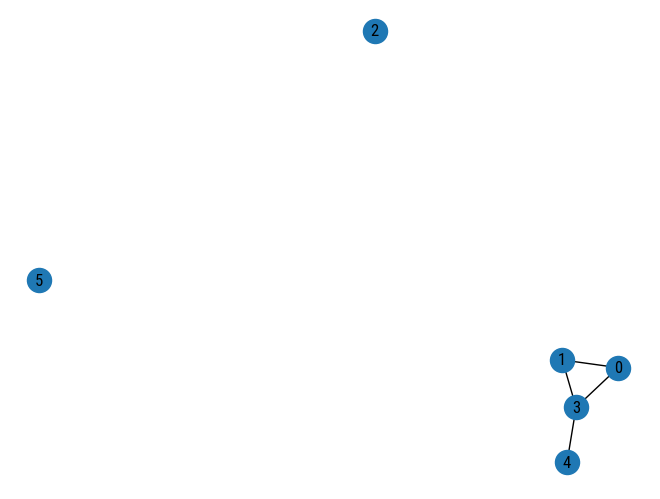

In [96]:
import networkx as nx
import matplotlib.pyplot as plt

# Get the network from the parameter dictionary
params = parameter_dictionaries[0]
print(params)
network = params['network']

# Create a graph from the network
graph = nx.Graph(network)

# Plot the graph
nx.draw(graph, with_labels=True)
plt.show()


In [97]:
parameter_dictionaries = generate_parameters(10000)  # Generate parameter dictionaries
results_df = run_simulations(parameter_dictionaries, number_of_steps=100000, show_bar=False)
display(results_df)


Running simulations: 100%|██████████| 10000/10000 [09:41<00:00, 17.18it/s]


,n_agents,n_edges_to_add,randomization_probability,uncertainty,n_experiments,true_consensus,true_consensus_alternative_stop
0,35,1,0.465802,0.001,1000,0.828571,0.828571
1,7,1,0.126811,0.001,1000,1.000000,1.000000
2,39,3,0.870653,0.001,1000,1.000000,1.000000
3,8,1,0.697600,0.001,1000,0.875000,0.875000
4,64,2,0.709067,0.001,1000,0.968750,0.968750
...,...,...,...,...,...,...,...
9995,44,4,0.453453,0.001,1000,1.000000,1.000000
9996,16,1,0.161439,0.001,1000,1.000000,1.000000
9997,67,2,0.138573,0.001,1000,1.000000,1.000000
9998,36,3,0.367534,0.001,1000,1.000000,1.000000


In [98]:

 
    # Preparing the data
X = results_df[['n_agents', 'n_edges_to_add', 'randomization_probability']]
y = results_df['true_consensus'].astype(int)  # Convert boolean to integer

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LogisticGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ).fit(X_train, y_train)

print(f"Model for {network_type}:")
print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())

Model for complete:
Accuracy on training data: 0.8481428571428572
Accuracy on test data: 0.8496666666666667
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      9.5573
Link Function:                        LogitLink Log Likelihood:                                 -2388.4934
Number of Samples:                         7000 AIC:                                             4796.1014
                                                AICc:                                            4796.1363
                                                UBRE:                                               2.6862
                                                Scale:                                                 1.0
                                    

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_84390/2392922359.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


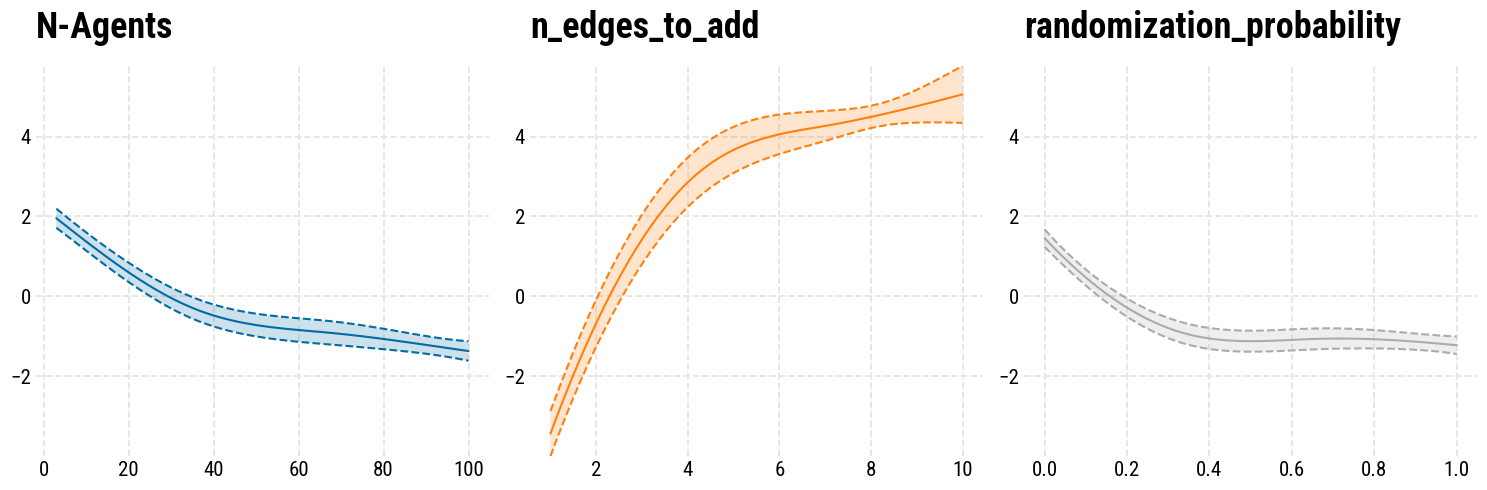

In [99]:
import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
plt.figure(figsize=(15, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels =['N-Agents', 'n_edges_to_add', 'randomization_probability']
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    plt.title(labels[i])
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel('')  # Remove y-axis label


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()
